### Import library

In [122]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb

import eli5
from eli5.sklearn import PermutationImportance


import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Data Load

In [123]:
base_path = "/root/"

dt = pd.read_csv(base_path + "train.csv")
dt_test = pd.read_csv(base_path + "test.csv")

df_bus = pd.read_csv(base_path + "bus_feature.csv")
df_metro = pd.read_csv(base_path + "subway_feature.csv")


extra_data_path = '/root/extra_data/'

va1 = pd.read_csv("/root/extra_data/2023년_공동주택_공시가격_정보.csv", encoding="cp949")
coords = pd.read_csv(extra_data_path + "coords.csv")

In [124]:
df_zones_original = pd.read_csv(extra_data_path + "2022_zoning_seoul.csv", encoding='euc-kr')
df_academies = pd.read_csv(extra_data_path + "2022_학생_1만명당_사설학원수_20240326124719.csv", encoding='euc-kr')
df_interest_rate = pd.read_csv(extra_data_path + "base_rate.csv")
unempl_rate = pd.read_csv(extra_data_path + "서울시_월별실업률_2007_2024.csv", encoding="euc-kr")

In [125]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

### before preprocess

In [126]:
dt['구'] = dt['시군구'].map(lambda x : x.split()[1])
dt['동'] = dt['시군구'].map(lambda x : x.split()[2])

dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])

In [127]:
mean_val_by_gu = dt.groupby("구")["target"].mean().sort_values(ascending=False)
mean_val_by_dong = dt.groupby("동")["target"].mean().sort_values(ascending=False)
std_val_by_gu = dt.groupby("구")["target"].std().sort_values(ascending=False)
std_val_by_dong = dt.groupby("동")["target"].std().sort_values(ascending=False)

### Data preprocessing

In [128]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
df = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [129]:
# 필요 없어 보이는 columns 제거
drop_col = ['부번', 'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'k-관리비부과면적', '주차대수', '건축면적', '해제사유발생일', '단지소개기존clob', 'k-135㎡초과', '중개사소재지', '등기신청일자', '거래유형']
df.drop(drop_col, axis=1, inplace=True)

In [130]:
# 시군구 feaeture 처리
# 구와 동에 대한 Feature 수정
# df['구'] = df['시군구'].apply(lambda x:x.split()[1])
# df['동'] = df['시군구'].apply(lambda x:x.split()[2])
omg = ['용산구', '강남구', '서초구', '송파구', '성동구', '종로구']
is_omg = []
for x in df['구'].tolist():
    if x in omg:
        is_omg.append(1)
    else:
        is_omg.append(0)
df['개비싸'] = is_omg
df.loc[~df['구'].isin(omg), '동'] = 'Unknown' 

del df['시군구']

In [131]:
df['계약년'] = df['계약년월'].map(lambda x : x // 100)
df['계약월'] = df['계약년월'].map(lambda x : x % 100)

df["date"] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [132]:
# df['계약년'] = df['계약년월'].astype('str').map(lambda x : x[:4])
# df['계약월'] = df['계약년월'].astype('str').map(lambda x : x[4:])

In [133]:
df['is_public'] = df["k-전용면적별세대현황(60㎡이하)"].notnull()

In [134]:
drop_cols_k = ['k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',  'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-연면적']

df.drop(columns=drop_cols_k, inplace=True)

In [135]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
df['본번'] = df['본번'].astype('str')

In [136]:
order1_mean_gu = mean_val_by_gu.index.tolist()
order2_mean_dong = mean_val_by_dong.index.tolist()
order3_std_gu = std_val_by_gu.index.tolist()
order4_std_dong = std_val_by_dong.index.tolist()

In [137]:
# Create a dictionary to map district names to their corresponding label encoded values
gu_mapping1 = {district: label for label, district in enumerate(order1_mean_gu)}
gu_mapping2 = {district: label for label, district in enumerate(order3_std_gu)}
dong_mapping1 = {dong: label for label, dong in enumerate(order2_mean_dong)}
dong_mapping2 = {dong: label for label, dong in enumerate(order4_std_dong)}

df['구_encoded'] = df["구"].map(gu_mapping1)
df['구_std'] = df["구"].map(gu_mapping2)
df['동_encoded'] = df["동"].map(dong_mapping1)
df['동_std'] = df["동"].map(dong_mapping2)

In [138]:
seoul_bds = ["강남구", "영등포구", "용산구"]

df["has_bds"] = df["구"].apply(lambda x : 1 if x in seoul_bds else 0)

In [139]:
df['yrs_diff_built_contract'] = df['계약년'] - df['건축년도']
df['built_in3yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x <= 3 else 0)
df['built_in5yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x <= 5 else 0)
df['built_over30yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 30 else 0)
df['built_over35yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 35 else 0)
df['built_over40yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 40 else 0)

In [140]:
df['road'] = df['도로명'].apply(lambda x : x.split()[0] if len(x.split()) > 0 else x)
df['on_main_st'] = df['road'].apply(lambda x: not any(char.isdigit() for char in x))
del df['road']

#### extra data

##### 구별 특성

- 시군구 단위 용도지역 현황 (2022)

In [141]:
df_zones_original['주거지역_전용주거_비율'] = df_zones_original['주거지역_전용주거_소계'] / df_zones_original['도시지역 면적']
df_zones_original['주거지역_일반주거_비율'] = df_zones_original['주거지역_일반주거지역_소계'] / df_zones_original['도시지역 면적']
df_zones_original['주거지역_준주거_비율'] = df_zones_original['주거지역_준주거지역'] / df_zones_original['도시지역 면적']
df_zones_original['중심상업_비율'] = df_zones_original['상업지역_중심상업'] / df_zones_original['도시지역 면적']
df_zones_original['일반상업_비율'] = df_zones_original['상업지역_일반상업'] / df_zones_original['도시지역 면적']
df_zones_original['근린상업_비율'] = df_zones_original['상업지역_근린상업'] / df_zones_original['도시지역 면적']

In [142]:
df_zone_ratio = df_zones_original[['시군구', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율', '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율',
       '중심상업_비율', '일반상업_비율', '근린상업_비율']]

In [143]:
df_zone_ratio.rename(columns={'시군구': '구'}, inplace=True)

In [144]:
df = pd.merge(left=df, right=df_zone_ratio, on='구', how='left')

- 2022_학생_1만명당_사설학원수

In [145]:
df_academies.rename(columns={"자치구":"구"}, inplace=True)
df_academies.drop(columns=['초중고_학생수(명)', '사설학원수(개소)'], inplace=True)

In [146]:
df = pd.merge(left=df, right=df_academies, on='구', how='left')

#### 경제지표

- 기준금리

In [147]:
df_interest_rate.rename(columns={'날짜': 'date'}, inplace=True)
df_interest_rate['date'] = pd.to_datetime(df_interest_rate['date'])

In [148]:
df = pd.merge(df, df_interest_rate, on = 'date', how='left')

- KOSPI

In [149]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [150]:
kospi_df["KOSPI_MA5d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=5).mean())
kospi_df["KOSPI_MA20d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=20).mean())
kospi_df["KOSPI_MA60d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=60).mean())
kospi_df["KOSPI_MA120d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=120).mean())

In [151]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [152]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [153]:
kospi_df.drop(columns='date', inplace=True)

In [154]:
df[kospi_df.columns.tolist()] = df[kospi_df.columns.tolist()].interpolate(method='linear', axis=0)

- unempl

In [155]:
unempl_rate["시점"] = unempl_rate["시점"]*100
unempl_rate["시점"] = unempl_rate["시점"].astype(int)
unempl_rate.rename(columns={"계" : "unempl_rate_total", "남자": "unempl_male", "여자":"unempl_female"}, inplace=True)

In [156]:
df = pd.merge(left=df, right=unempl_rate, left_on="계약년월", right_on="시점", how="left")
df.drop(columns=['시점'], inplace=True)

##### 공시가격

In [157]:
# 'time_col' 데이터를 문자열 형태로 변환
df['계약년월'] = df['계약년월'].astype(str)
# 문자열 형태 데이터를 datetime 형태로 변환
df['계약년월'] = pd.to_datetime(df['계약년월'], format='%Y%m')
# 변환 확인
print(df['계약년월'].head())

0   2017-12-01
1   2017-12-01
2   2017-12-01
3   2018-01-01
4   2018-01-01
Name: 계약년월, dtype: datetime64[ns]


In [158]:
va1['도로명주소']= va1['도로명주소'].apply(lambda address: address.split()[2]+' '+address.split()[-1] )
va1.rename(columns={'도로명주소': '도로명',
                     '단지명':'아파트명'}, inplace=True)

In [159]:
va1 = va1[va1['시도']=='서울특별시']
va1 = va1.drop(columns={'기준월','법정동코드','읍면','특수지코드','특수지명','단지코드','동코드','호코드',})
va1['공시가격']=va1['공시가격']/10000

In [160]:
avg_price_by_road = va1.groupby('도로명')['공시가격'].mean().reset_index()
avg_price_by_road.columns = ['도로명', '평균공시가격']  # 열 이름 변경

df = pd.merge(df, avg_price_by_road, on='도로명', how='left')

In [161]:
grouped_prices = va1.groupby('도로명')['공시가격'].apply(list).reset_index()
grouped_prices.columns = ['도로명', '공시가격리스트']  # 열 이름 변경

# 기존 데이터프레임에 공시가격리스트 열 추가
df = pd.merge(df, grouped_prices, on='도로명', how='left')

In [162]:
# 좌표 CSV 파일에서 'street'을 인덱스로 설정
coords.set_index('street', inplace=True)

# dt 데이터프레임에서 null 값을 좌표 CSV 파일의 값으로 대체
for index, row in dt.iterrows():
    if pd.isnull(row['좌표X']) or pd.isnull(row['좌표Y']):
        street = row['도로명']
        if street in coords.index:
            dt.at[index, '좌표X'] = coords.loc[street, '좌표X']
            dt.at[index, '좌표Y'] = coords.loc[street, '좌표Y']

In [163]:
from math import radians, cos, sin, sqrt, atan2
from scipy.spatial import cKDTree
# Vincenty 공식을 사용하여 두 점 간의 거리를 계산하는 함수
def calculate_distance(lat1, lon1, lat2, lon2):
    # 지구의 반경 (단위: m)
    R = 6371e3
    
    # 위도 및 경도를 라디안으로 변환
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)
    
    # 두 점 간의 차이를 계산
    delta_lon = lon2_rad - lon1_rad
    
    # Vincenty 공식 계산
    a = sin((lat2_rad - lat1_rad) / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(delta_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return distance
def nearest_metro_station_distance(dt_row, kdtree, df_metro):
    dt_coords = (dt_row['좌표Y'], dt_row['좌표X'])
    if np.isnan(dt_coords[0]) or np.isnan(dt_coords[1]):  # 좌표값이 null인 경우
        return np.nan  # NaN으로 반환하여 해당 위치에 대한 거리를 없음으로 표시
    else:
        nearest_idx = kdtree.query(dt_coords)[1]
        nearest_coords = (df_metro.loc[nearest_idx, '위도'], df_metro.loc[nearest_idx, '경도'])
        distance = calculate_distance(dt_coords[1], dt_coords[0], nearest_coords[1], nearest_coords[0])
        return distance

# 지하철 역세권 데이터프레임에 역세권 여부를 판별하는 열 추가하는 함수
def add_metro_station_proximity_column(dt, df_metro, proximity_threshold):
    # 지하철 역 데이터에서 좌표를 추출하여 KD 트리 인덱스 생성
    metro_station_coords = df_metro[['위도', '경도']].dropna().values  # null 값을 제외하고 좌표 추출
    kdtree_metro_station = cKDTree(metro_station_coords)
    
    # dt 데이터프레임에 역세권 여부를 판별하는 열 추가
    dt['가장가까운_지하철역_거리'] = dt.apply(nearest_metro_station_distance, args=(kdtree_metro_station, df_metro,), axis=1)
    
    # 최근접 지하철 역과의 거리가 기준 거리 이내인지 판별하여 역세권 여부를 나타내는 열 추가
    dt['지하철역세권'] = dt['가장가까운_지하철역_거리'] <= proximity_threshold

# 지하철 역세권을 판별하기 위한 지하철 역과의 최대 거리 설정 (예: 115m)
proximity_threshold_metro_station = 1000

# 역세권 여부를 나타내는 열 추가
add_metro_station_proximity_column(df, df_metro, proximity_threshold_metro_station)

In [164]:
from math import radians, cos, sin, sqrt, atan2
from scipy.spatial import cKDTree
# Vincenty 공식을 사용하여 두 점 간의 거리를 계산하는 함수
def calculate_distance(lat1, lon1, lat2, lon2):
    # 지구의 반경 (단위: m)
    R = 6371e3
    
    # 위도 및 경도를 라디안으로 변환
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)
    
    # 두 점 간의 차이를 계산
    delta_lon = lon2_rad - lon1_rad
    
    # Vincenty 공식 계산
    a = sin((lat2_rad - lat1_rad) / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(delta_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return distance

# 최근접 버스 정류장과의 거리 계산 함수
def nearest_bus_stop_distance(dt_row, kdtree, df_bus):
    dt_coords = (dt_row['좌표Y'], dt_row['좌표X'])
    if np.isnan(dt_coords[0]) or np.isnan(dt_coords[1]):  # 좌표값이 null인 경우
        return np.nan  # NaN으로 반환하여 해당 위치에 대한 거리를 없음으로 표시
    else:
        nearest_idx = kdtree.query(dt_coords)[1]
        nearest_coords = (df_bus.loc[nearest_idx, 'Y좌표'], df_bus.loc[nearest_idx, 'X좌표'])
        distance = calculate_distance(dt_coords[1], dt_coords[0], nearest_coords[1], nearest_coords[0])
        return distance

# 버스 정류장 세권 데이터프레임에 역세권 여부를 판별하는 열 추가하는 함수
def add_bus_stop_proximity_column(dt, df_bus, proximity_threshold):
    # 버스 정류장 데이터에서 좌표를 추출하여 KD 트리 인덱스 생성
    bus_stop_coords = df_bus[['Y좌표', 'X좌표']].dropna().values  # null 값을 제외하고 좌표 추출
    kdtree_bus_stop = cKDTree(bus_stop_coords)
    
    # dt 데이터프레임에 역세권 여부를 판별하는 열 추가
    dt['가장가까운_버스정류장_거리'] = dt.apply(nearest_bus_stop_distance, args=(kdtree_bus_stop, df_bus,), axis=1)
    
    # 최근접 버스 정류장과의 거리가 기준 거리 이내인지 판별하여 역세권 여부를 나타내는 열 추가
    dt['버스정류장세권'] = dt['가장가까운_버스정류장_거리'] <= proximity_threshold

# 버스 정류장 세권을 판별하기 위한 버스 정류장과의 최대 거리 설정 (예: 115m)
proximity_threshold_bus_stop = 800

# 역세권 여부를 나타내는 열 추가
add_bus_stop_proximity_column(df, df_bus, proximity_threshold_bus_stop)

In [165]:
df = df.drop(columns={'좌표X','좌표Y','가장가까운_지하철역_거리','가장가까운_버스정류장_거리'})
df['공시가격리스트']= df['공시가격리스트'].astype(str)

In [166]:
df['평균공시가격']=df['평균공시가격'].interpolate(method='linear', axis=0)

In [167]:
# # '평균공시가격'이 null인 행을 구합니다.
# null_rows = df[df['평균공시가격'].isnull()]

# # '구'별 '평균공시가격'의 평균값을 구합니다.
# avg_prices_by_district = df.groupby('구')['평균공시가격'].mean()

# # '평균공시가격'이 null인 행의 '구' 값을 기준으로 평균값을 가져와서 채웁니다.
# for index, row in null_rows.iterrows():
#     district = row['구']
#     avg_price = avg_prices_by_district[district]
#     df.at[index, '평균공시가격'] = avg_price


In [171]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

# 수치형 데이터를 어떻게 채워야 될지 모르겠음 -> 걍 빼.
# 좌표X, 좌표Y 를 리니어로 채우는건 혼동을 줄 수 있는 데이터임
df.drop(columns=['k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',], inplace=True)

# 범주형 변수에 대한 보간
df[categorical_columns] = df[categorical_columns].fillna('NULL')

연속형 변수: ['전용면적(㎡)', '계약일', '층', '건축년도', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'target', 'is_test', '개비싸', '계약년', '계약월', 'is_public', '구_encoded', '구_std', '동_encoded', '동_std', 'has_bds', 'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs', 'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'on_main_st', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율', '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율', '중심상업_비율', '일반상업_비율', '근린상업_비율', '학생1만명당_사설학원수(개소)', '기준금리', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액', 'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d', 'KOSPI_MA120d', 'Close_delay120d', 'unempl_rate_total', 'unempl_male', 'unempl_female', '평균공시가격', '지하철역세권', '버스정류장세권']
범주형 변수: ['번지', '본번', '아파트명', '계약년월', '도로명', '구', '동', 'date', '공시가격리스트']


#### del cols before modeling

In [173]:
drop_cols_before_train = ['date', '계약월', '계약일', '계약년']

df.drop(columns=drop_cols_before_train, inplace=True)

In [174]:
df.columns = df.columns.str.replace('[^\w\s]', '')
df.columns = df.columns.str.replace(' ', '_')

In [176]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명', 'target', '구',
       '동', 'is_test', '개비싸', 'is_public', '구_encoded', '구_std', '동_encoded',
       '동_std', 'has_bds', 'yrs_diff_built_contract', 'built_in3yrs',
       'built_in5yrs', 'built_over30yrs', 'built_over35yrs', 'built_over40yrs',
       'on_main_st', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율',
       '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율', '중심상업_비율', '일반상업_비율',
       '근린상업_비율', '학생1만명당_사설학원수개소', '기준금리', 'Close', '대비', '등락률', '거래량',
       '거래대금', '상장시가총액', 'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d',
       'KOSPI_MA120d', 'Close_delay120d', 'unempl_rate_total', 'unempl_male',
       'unempl_female', '평균공시가격', '공시가격리스트', '지하철역세권', '버스정류장세권'],
      dtype='object')

# Train

In [177]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 55) (9272, 55)


In [178]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118822 entries, 0 to 1118821
Data columns (total 55 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   번지                       1118822 non-null  object        
 1   본번                       1118822 non-null  object        
 2   아파트명                     1118822 non-null  object        
 3   전용면적                     1118822 non-null  float64       
 4   계약년월                     1118822 non-null  datetime64[ns]
 5   층                        1118822 non-null  int64         
 6   건축년도                     1118822 non-null  int64         
 7   도로명                      1118822 non-null  object        
 8   target                   1118822 non-null  float64       
 9   구                        1118822 non-null  object        
 10  동                        1118822 non-null  object        
 11  개비싸                      1118822 non-null  int64         
 12  

In [179]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
df_test['target'] = 0

In [180]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if column == '계약년월':
        continue
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', 'target', '개비싸', 'is_public', '구_encoded', '구_std', '동_encoded', '동_std', 'has_bds', 'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs', 'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'on_main_st', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율', '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율', '중심상업_비율', '일반상업_비율', '근린상업_비율', '학생1만명당_사설학원수개소', '기준금리', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액', 'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d', 'KOSPI_MA120d', 'Close_delay120d', 'unempl_rate_total', 'unempl_male', 'unempl_female', '평균공시가격', '지하철역세권', '버스정류장세권']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '구', '동', '공시가격리스트']


In [181]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


In [182]:
def preprocess_feature_name(feature_name):
  """특수 문자를 제거하고 소문자로 변환합니다."""
  feature_name = feature_name.replace("-", "_")
  feature_name = feature_name.replace(",", "_")
  feature_name = feature_name.replace(".", "_")
  feature_name = feature_name.replace("(", "_")
  feature_name = feature_name.replace(")", "_")
  feature_name = feature_name.lower()
  return feature_name

def apply_preprocessed_feature_names(df_train):
  """데이터 프레임의 feature 이름을 수정합니다."""
  df_train.columns = [preprocess_feature_name(feature) for feature in df_train.columns]
  return df_train

# 데이터 프레임에 적용
df_train = apply_preprocessed_feature_names(df_train.copy())
df_test = apply_preprocessed_feature_names(df_test.copy())

### Holdout Using optuna

In [27]:
y_train = df_train['target']
X_train = df_train.drop(['target', '계약년월'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [28]:
import optuna

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    num_leaves = trial.suggest_int('num_leaves', 100, 1000)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
    feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

    # Create the LGBMRegressor model with the suggested hyperparameters
    gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
                            min_child_samples=min_child_samples, feature_fraction=feature_fraction,
                            bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

    # Train the model
    gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
    
    # Compute the validation RMSE
    val_rmse = gbm.best_score_['valid_1']['rmse']
    return val_rmse

def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = lgb.LGBMRegressor(**best_params)

    # Train the final model with early stopping and evaluation logging
    best_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
                              lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

    return best_model

In [29]:
best_model = optimize_hyperparameters(n_trials=5)

[I 2024-03-28 08:05:39,814] A new study created in memory with name: no-name-26ce6094-c14d-455b-9700-3147daeb8c7e


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7142.73	training's l2: 5.10185e+07	valid_1's rmse: 7505	valid_1's l2: 5.6325e+07
[200]	training's rmse: 6242.8	training's l2: 3.89726e+07	valid_1's rmse: 6731.26	valid_1's l2: 4.53098e+07
[300]	training's rmse: 5876.97	training's l2: 3.45388e+07	valid_1's rmse: 6434.66	valid_1's l2: 4.14048e+07
[400]	training's rmse: 5650.03	training's l2: 3.19229e+07	valid_1's rmse: 6266.79	valid_1's l2: 3.92727e+07
[500]	training's rmse: 5472.53	training's l2: 2.99485e+07	valid_1's rmse: 6140.11	valid_1's l2: 3.7701e+07
[600]	training's rmse: 5333.62	training's l2: 2.84475e+07	valid_1's rmse: 6045.87	valid_1's l2: 3.65525e+07
[700]	training's rmse: 5214.82	training's l2: 2.71944e+07	valid_1's rmse: 5970.49	valid_1's l2: 3.56468e+07
[800]	training's rmse: 5109.18	training's l2: 2.61038e+07	valid_1's rmse: 5910.39	valid_1's l2: 3.49327e+07
[900]	training's rmse: 5022.8	training's l2: 2.52286e+07	valid_1's rmse: 5865.06	

[I 2024-03-28 08:06:26,099] Trial 0 finished with value: 5567.834083025395 and parameters: {'n_estimators': 3579, 'max_depth': 11, 'num_leaves': 190, 'min_child_samples': 150, 'feature_fraction': 0.8982145049769417, 'bagging_fraction': 0.8006729371268377, 'lambda_l1': 9.052964862638721e-07, 'lambda_l2': 0.6491286961797076}. Best is trial 0 with value: 5567.834083025395.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6813.41	training's l2: 4.64225e+07	valid_1's rmse: 7258.51	valid_1's l2: 5.2686e+07
[200]	training's rmse: 5952.09	training's l2: 3.54274e+07	valid_1's rmse: 6534.72	valid_1's l2: 4.27025e+07
[300]	training's rmse: 5561.31	training's l2: 3.09281e+07	valid_1's rmse: 6245.75	valid_1's l2: 3.90094e+07
[400]	training's rmse: 5307.96	training's l2: 2.81744e+07	valid_1's rmse: 6086.65	valid_1's l2: 3.70474e+07
[500]	training's rmse: 5121.32	training's l2: 2.62279e+07	valid_1's rmse: 5983.04	valid_1's l2: 3.57967e+07
[600]	training's rmse: 4965.61	training's l2: 2.46573e+07	valid_1's rmse: 5895.17	valid_1's l2: 3.4753e+07
[700]	training's rmse: 4836.17	training's l2: 2.33886e+07	valid_1's rmse: 5828.37	valid_1's l2: 3.39699e+07
[800]	training's rmse: 4726.85	training's l2: 2.23432e+07	valid_1's rmse: 5780.38	valid_1's l2: 3.34128e+07
[900]	training's rmse: 4625.87	training's l2: 2.13987e+07	valid_1's rmse: 573

[I 2024-03-28 08:07:17,817] Trial 1 finished with value: 5542.22863158946 and parameters: {'n_estimators': 4358, 'max_depth': 45, 'num_leaves': 311, 'min_child_samples': 237, 'feature_fraction': 0.7640908608931953, 'bagging_fraction': 0.6690234510977073, 'lambda_l1': 2.309439118528166e-08, 'lambda_l2': 0.06201368201312198}. Best is trial 1 with value: 5542.22863158946.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7339.59	training's l2: 5.38695e+07	valid_1's rmse: 7739.28	valid_1's l2: 5.98965e+07
[200]	training's rmse: 6418.39	training's l2: 4.11957e+07	valid_1's rmse: 6907.2	valid_1's l2: 4.77094e+07
[300]	training's rmse: 5995.91	training's l2: 3.59509e+07	valid_1's rmse: 6542.84	valid_1's l2: 4.28087e+07
[400]	training's rmse: 5716.05	training's l2: 3.26732e+07	valid_1's rmse: 6331.51	valid_1's l2: 4.00881e+07
[500]	training's rmse: 5513.93	training's l2: 3.04034e+07	valid_1's rmse: 6187.93	valid_1's l2: 3.82905e+07
[600]	training's rmse: 5359.86	training's l2: 2.87281e+07	valid_1's rmse: 6088.2	valid_1's l2: 3.70662e+07
[700]	training's rmse: 5224.14	training's l2: 2.72917e+07	valid_1's rmse: 5999.49	valid_1's l2: 3.59939e+07
[800]	training's rmse: 5109.6	training's l2: 2.6108e+07	valid_1's rmse: 5936.39	valid_1's l2: 3.52408e+07
[900]	training's rmse: 5008.33	training's l2: 2.50834e+07	valid_1's rmse: 5883.

[I 2024-03-28 08:07:59,682] Trial 2 finished with value: 5720.553326579118 and parameters: {'n_estimators': 1427, 'max_depth': 31, 'num_leaves': 344, 'min_child_samples': 416, 'feature_fraction': 0.8233283527019659, 'bagging_fraction': 0.8520531414652546, 'lambda_l1': 7.094629856787695e-07, 'lambda_l2': 0.0010227511214542379}. Best is trial 1 with value: 5542.22863158946.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7024.68	training's l2: 4.93462e+07	valid_1's rmse: 7400.72	valid_1's l2: 5.47707e+07
[200]	training's rmse: 6084.73	training's l2: 3.7024e+07	valid_1's rmse: 6607.98	valid_1's l2: 4.36654e+07
[300]	training's rmse: 5667.73	training's l2: 3.21231e+07	valid_1's rmse: 6286.2	valid_1's l2: 3.95163e+07
[400]	training's rmse: 5413.07	training's l2: 2.93013e+07	valid_1's rmse: 6115.63	valid_1's l2: 3.74009e+07
[500]	training's rmse: 5220.59	training's l2: 2.72546e+07	valid_1's rmse: 5998.94	valid_1's l2: 3.59872e+07
[600]	training's rmse: 5062.15	training's l2: 2.56254e+07	valid_1's rmse: 5905.78	valid_1's l2: 3.48783e+07
[700]	training's rmse: 4930.59	training's l2: 2.43107e+07	valid_1's rmse: 5835.11	valid_1's l2: 3.40485e+07
[800]	training's rmse: 4823.94	training's l2: 2.32704e+07	valid_1's rmse: 5779.45	valid_1's l2: 3.34021e+07
[900]	training's rmse: 4729.19	training's l2: 2.23652e+07	valid_1's rmse: 573

[I 2024-03-28 08:08:39,727] Trial 3 finished with value: 5573.672853297609 and parameters: {'n_estimators': 1674, 'max_depth': 25, 'num_leaves': 268, 'min_child_samples': 217, 'feature_fraction': 0.5346230420999447, 'bagging_fraction': 0.533306894235783, 'lambda_l1': 7.429044694120797e-06, 'lambda_l2': 1.4987131342546565e-08}. Best is trial 1 with value: 5542.22863158946.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7226.32	training's l2: 5.22196e+07	valid_1's rmse: 7607.99	valid_1's l2: 5.78815e+07
[200]	training's rmse: 6397.26	training's l2: 4.0925e+07	valid_1's rmse: 6859.28	valid_1's l2: 4.70497e+07
[300]	training's rmse: 6048.39	training's l2: 3.6583e+07	valid_1's rmse: 6560.11	valid_1's l2: 4.3035e+07
[400]	training's rmse: 5808.56	training's l2: 3.37394e+07	valid_1's rmse: 6380.17	valid_1's l2: 4.07066e+07
[500]	training's rmse: 5626.4	training's l2: 3.16564e+07	valid_1's rmse: 6249.34	valid_1's l2: 3.90542e+07
[600]	training's rmse: 5482.48	training's l2: 3.00576e+07	valid_1's rmse: 6153.28	valid_1's l2: 3.78629e+07
[700]	training's rmse: 5358.78	training's l2: 2.87165e+07	valid_1's rmse: 6075.71	valid_1's l2: 3.69142e+07
[800]	training's rmse: 5264.5	training's l2: 2.77149e+07	valid_1's rmse: 6013.89	valid_1's l2: 3.61669e+07
[900]	training's rmse: 5173.08	training's l2: 2.67607e+07	valid_1's rmse: 5961.2

[I 2024-03-28 08:09:17,170] Trial 4 finished with value: 5806.377758789455 and parameters: {'n_estimators': 1336, 'max_depth': 19, 'num_leaves': 994, 'min_child_samples': 428, 'feature_fraction': 0.5094263092119135, 'bagging_fraction': 0.6356998897999219, 'lambda_l1': 0.9319792300439395, 'lambda_l2': 0.000546901984905367}. Best is trial 1 with value: 5542.22863158946.


[LightGBM] [Warning] feature_fraction is set=0.7640908608931953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7640908608931953
[LightGBM] [Warning] lambda_l2 is set=0.06201368201312198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06201368201312198
[LightGBM] [Warning] lambda_l1 is set=2.309439118528166e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.309439118528166e-08
[LightGBM] [Warning] bagging_fraction is set=0.6690234510977073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6690234510977073
[LightGBM] [Warning] feature_fraction is set=0.7640908608931953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7640908608931953
[LightGBM] [Warning] lambda_l2 is set=0.06201368201312198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06201368201312198
[LightGBM] [Warning] lambda_l1 is set=2.309439118528166e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.309439118528166

In [30]:
best_model.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 3824.3930154556265),
                          ('l2', 14625981.93666578)]),
             'valid_1': OrderedDict([('rmse', 5542.22863158946),
                          ('l2', 30716298.204809975)])})

In [31]:
X_test = df_test.drop(['target', '계약년월'], axis=1)
real_test_pred = best_model.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('holdout_optuna_output_interpolate_1000_800.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.7640908608931953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7640908608931953
[LightGBM] [Warning] lambda_l2 is set=0.06201368201312198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06201368201312198
[LightGBM] [Warning] lambda_l1 is set=2.309439118528166e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.309439118528166e-08
[LightGBM] [Warning] bagging_fraction is set=0.6690234510977073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6690234510977073


In [32]:
preds_df.median()

target    85247.0
dtype: float64

In [33]:
preds_df.describe()

,target
count,9.272000e+03
mean,1.054854e+05
std,7.716321e+04
min,6.595000e+03
25%,6.090450e+04
50%,8.524700e+04
75%,1.242950e+05
max,1.251800e+06


### holdout

In [183]:
def holdout_lgb(X, y, test=pd.DataFrame, test_size=0.2, random_state=2023 ,gbm = lgb.LGBMRegressor(n_estimators=1000), early_stopping=10, log_evaluation=10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    gbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
                   lgb.log_evaluation(period=log_evaluation, show_stdv=True)])
    
    if not test.empty:
        real_test_pred = gbm.predict(test)
        preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
        preds_df.to_csv('holdout_output.csv', index=False)

        # return preds_df

    return gbm
        
    

In [184]:
y_train = df_train['target']
X_train = df_train.drop(['target', '계약년월'], axis=1)
X_test = df_test.drop(['target', '계약년월'], axis=1)
gbm = lgb.LGBMRegressor(n_estimators=2000, max_depth=20, num_leaves=100,
                            min_child_samples=60, feature_fraction=0.8,
                            bagging_fraction=0.8)
gbm = holdout_lgb(X_train,y_train, test=X_test, gbm=gbm)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5556
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 53
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_

In [185]:
gbm.best_score_['valid_1']['rmse']

5911.201216207049

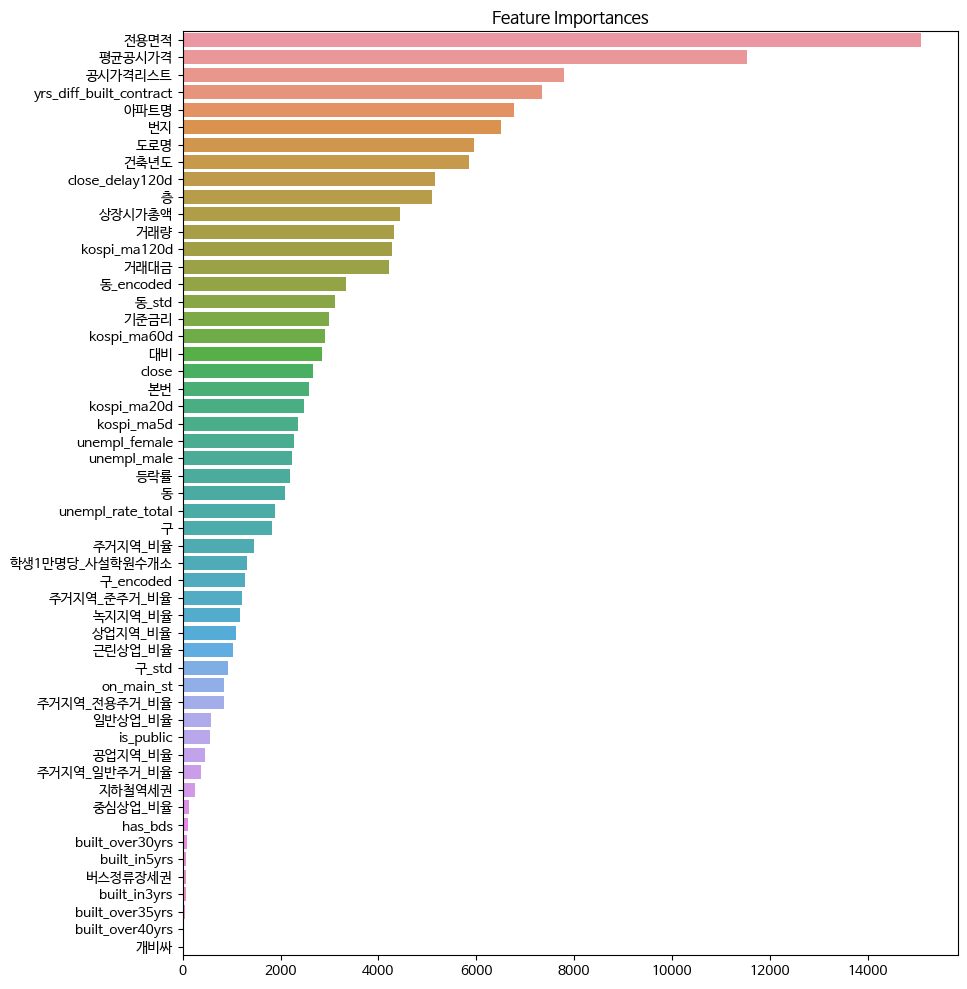

In [186]:
importances = pd.Series(gbm.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 12))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

## 데이터 분리

In [33]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit

### K-Fold

In [57]:
def k_fold_lgb(X, y, test=pd.DataFrame, n_splits=5, gbm=lgb.LGBMRegressor(n_estimators=1000), early_stopping=10, log_evaluation=10):
    # Kfold 함수를 선언합니다.
    kf = KFold(n_splits=n_splits)
    # 학습 데이터를 Kfold로 나눕니다.
    train_folds = kf.split(X, y)

    fold_save_files = []

    for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
        print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

        # index를 통해 fold의 학습세트를 가져옵니다.
        X_train_fold = X.iloc[train_idx, :]
        Y_train_fold = y[train_idx]

        # index를 통해 fold의 평가세트를 가져옵니다.
        X_valid_fold = X.iloc[valid_idx, :]
        Y_valid_fold = y[valid_idx]

        # fold의 데이터로 학습을 진행합니다.
        gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
            eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
            eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                    lgb.log_evaluation(period=log_evaluation, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
        )

        # 각 fold별 학습한 모델을 저장합니다.
        file_name = f"kfold{fold_idx}_gbm.pkl"
        joblib.dump(gbm, file_name)
        print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
        fold_save_files.append(file_name)

    # 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
    # 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
    if not test.empty:
        total_predicts = np.zeros(len(X_test))

        for file_name in fold_save_files:
            gbm_trained = joblib.load(file_name)
            fold_predicts = gbm_trained.predict(X_test)

            total_predicts += fold_predicts / len(fold_save_files)
        
        # 앞서 예측한 예측값들을 저장합니다.
        preds_df = pd.DataFrame(total_predicts.astype(int), columns=["target"])
        preds_df.to_csv('k-fold_output.csv', index=False)

        return preds_df

In [58]:
k_fold_lgb(X_train, y_train, X_test)

--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1754
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 16
[LightGBM] [Info] Start training from score 57132.425269
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 26721.6	training's l2: 7.14045e+08	valid_1's rmse: 28235.3	valid_1's l2: 7.97234e+08
[20]	training's rmse: 20413.5	training's l2: 4.1671e+08	valid_1's rmse: 21702.8	valid_1's l2: 4.71013e+08
[30]	training's rmse: 17537.8	training's l2: 3.07573e+08	valid_1's rmse: 18893.4	valid_1's l2: 3.56962e+08
[40]	training's rmse: 16009	training's l2: 2.56289e+08	valid_1's rmse: 17498.4	valid_1's l2: 3.06193e+08
[50]	training's rmse: 14981.8	training's l2: 2.24453e+08	valid_

,target
0,206857
1,266861
2,332427
3,265358
4,221849
...,...
9267,86171
9268,85626
9269,91401
9270,76948


### Best 3 K-Fold

In [63]:
top_3_files = ["kfold2_gbm.pkl", "kfold3_gbm.pkl", "kfold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    total_predicts += fold_predicts / len(top_3_files)

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(total_predicts.astype(int), columns=["target"])
preds_df.to_csv('k-fold_output.csv', index=False)


### Time series Split

In [69]:
def time_series_lgb(X, y, test=pd.DataFrame, n_splits=5, gbm=lgb.LGBMRegressor(n_estimators=1000), early_stopping=10, log_evaluation=10):
    # TimeSeriesSplit 함수를 선언합니다.
    kf = TimeSeriesSplit(n_splits=n_splits)
    train_folds = kf.split(X, y)

    fold_save_files = []

    for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
        display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

        # index를 통해 fold의 학습세트를 가져옵니다.
        X_train_fold = X.iloc[train_idx, :]
        Y_train_fold = y[train_idx]

        # index를 통해 fold의 평가세트를 가져옵니다.
        X_valid_fold = X.iloc[valid_idx, :]
        Y_valid_fold = y[valid_idx]

        # fold의 데이터로 학습을 진행합니다.
        gbm = lgb.LGBMRegressor(n_estimators=1000)
        gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
            eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
            eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
            callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                    lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
        )

        # 각 fold별 학습한 모델을 저장합니다.
        file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
        joblib.dump(gbm, file_name)
        display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
        fold_save_files.append(file_name)

    # 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
    # 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
    if not test.empty:
        total_predicts = np.zeros(len(X_test))

        for file_name in fold_save_files:
            gbm_trained = joblib.load(file_name)
            fold_predicts = gbm_trained.predict(X_test)

            total_predicts += fold_predicts / len(fold_save_files)
        
        # 앞서 예측한 예측값들을 저장합니다.
        preds_df = pd.DataFrame(total_predicts.astype(int), columns=["target"])
        preds_df.to_csv('time-series_output.csv', index=False)

        return preds_df

In [70]:
X_train = df_train.drop(['target'], axis=1)
Y_train = df_train['target']

X_train = X_train.sort_values(by='계약년월') # 시간순으로 정렬합니다.
Y_train = Y_train.reindex(X_train.index) # 정렬된 X_train의 인덱스에 맞추어 Y_train도 정렬해줍니다.

X_train = X_train.reset_index(drop=True) # 인덱스를 재정렬 해줍니다.
Y_train = Y_train.reset_index(drop=True)

del X_train['계약년월'] # 시간에 대한 정보를 지웁니다.

X_test = df_test.drop(['target', '계약년월'], axis=1)

time_series_lgb(X_train, Y_train, X_test)

'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1790
[LightGBM] [Info] Number of data points in the train set: 186472, number of used features: 16
[LightGBM] [Info] Start training from score 41193.008543
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 16785	training's l2: 2.81736e+08	valid_1's rmse: 17566.5	valid_1's l2: 3.08581e+08
[20]	training's rmse: 12765.5	training's l2: 1.62958e+08	valid_1's rmse: 13712.8	valid_1's l2: 1.88041e+08
[30]	training's rmse: 11191.3	training's l2: 1.25245e+08	valid_1's rmse: 12559.3	valid_1's l2: 1.57735e+08
[40]	training's rmse: 10345.2	training's l2: 1.07023e+08	valid_1's rmse: 12086	valid_1's l2: 1.4607e+08
[50]	training's rmse: 9750.8	training's l2: 9.50781e+07	valid_1's rmse: 11829.6	valid_1's l2: 1.39941e

'--------0번째 fold는 timeseries_fold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 372942, number of used features: 16
[LightGBM] [Info] Start training from score 43548.686345
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 17310.4	training's l2: 2.99649e+08	valid_1's rmse: 16689.2	valid_1's l2: 2.7853e+08
[20]	training's rmse: 13052.2	training's l2: 1.7036e+08	valid_1's rmse: 12913	valid_1's l2: 1.66745e+08
[30]	training's rmse: 11448.1	training's l2: 1.31059e+08	valid_1's rmse: 11785.5	valid_1's l2: 1.38899e+08
[40]	training's rmse: 10545.3	training's l2: 1.11203e+08	valid_1's rmse: 11200.3	valid_1's l2: 1.25447e+08
[50]	training's rmse: 9931.93	training's l2: 9.86433e+07	valid_1's rmse: 10747.6	valid_1's l2: 1.1551

'--------1번째 fold는 timeseries_fold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1729
[LightGBM] [Info] Number of data points in the train set: 559412, number of used features: 16
[LightGBM] [Info] Start training from score 44352.484621
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 17186.2	training's l2: 2.95365e+08	valid_1's rmse: 22757.8	valid_1's l2: 5.17919e+08
[20]	training's rmse: 13028.6	training's l2: 1.69745e+08	valid_1's rmse: 18161.8	valid_1's l2: 3.2985e+08
[30]	training's rmse: 11360.7	training's l2: 1.29066e+08	valid_1's rmse: 16391.2	valid_1's l2: 2.68673e+08
[40]	training's rmse: 10417.4	training's l2: 1.08522e+08	valid_1's rmse: 15265.1	valid_1's l2: 2.33024e+08
[50]	training's rmse: 9802.39	training's l2: 9.60868e+07	valid_1's rmse: 14442.5	valid_1's l2: 2.0

'--------2번째 fold는 timeseries_fold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 745882, number of used features: 16
[LightGBM] [Info] Start training from score 46766.465732
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 18240.4	training's l2: 3.32713e+08	valid_1's rmse: 39607.6	valid_1's l2: 1.56876e+09
[20]	training's rmse: 13842.7	training's l2: 1.91619e+08	valid_1's rmse: 33651.5	valid_1's l2: 1.13242e+09
[30]	training's rmse: 12073	training's l2: 1.45757e+08	valid_1's rmse: 30134	valid_1's l2: 9.08059e+08
[40]	training's rmse: 11030.9	training's l2: 1.2168e+08	valid_1's rmse: 27874.9	valid_1's l2: 7.77007e+08
[50]	training's rmse: 10395.4	training's l2: 1.08065e+08	valid_1's rmse: 26598.5	valid_1's l2: 7.07478

'--------3번째 fold는 timeseries_fold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 932352, number of used features: 16
[LightGBM] [Info] Start training from score 51316.276133
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 21811.6	training's l2: 4.75744e+08	valid_1's rmse: 56580.1	valid_1's l2: 3.20131e+09
[20]	training's rmse: 16559.2	training's l2: 2.74207e+08	valid_1's rmse: 47350.4	valid_1's l2: 2.24206e+09
[30]	training's rmse: 14330.8	training's l2: 2.05371e+08	valid_1's rmse: 42334.4	valid_1's l2: 1.7922e+09
[40]	training's rmse: 13001.9	training's l2: 1.6905e+08	valid_1's rmse: 39504.8	valid_1's l2: 1.56063e+09
[50]	training's rmse: 12143.6	training's l2: 1.47466e+08	valid_1's rmse: 37816.4	valid_1's l2: 1.43

'--------4번째 fold는 timeseries_fold4_gbm.pkl에 저장되었습니다.--------\n\n'

,target
0,101047
1,127130
2,162975
3,137952
4,113692
...,...
9267,45284
9268,45050
9269,55072
9270,49209
